In [1]:
import os
os.chdir('../')

## Load data

1111  {
    "rgb": "tensor[1, 3, 228, 304] n=207936 (0.8Mb) x∈[0., 0.996] μ=0.481 σ=0.234 cuda:0",
    "dep": "tensor[1, 1, 228, 304] n=69312 (0.3Mb) x∈[0., 3.553] μ=0.013 σ=0.203 cuda:0",
    "gt": "tensor[1, 1, 228, 304] n=69312 (0.3Mb) x∈[1.811, 3.593] μ=2.924 σ=0.405 cuda:0"
}


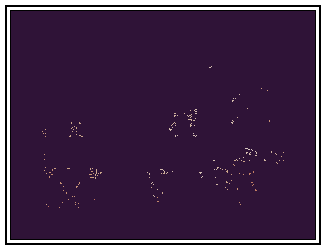

In [2]:
import torch
batch = torch.load('tmp/batch.pth')
import jhutil; jhutil.jhprint(1111, batch)

(batch["dep"] / 4).chans

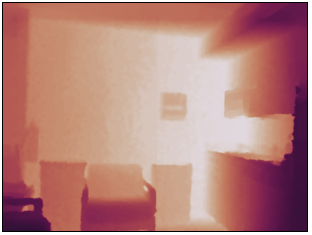

In [3]:
depth_gt = batch["gt"][0][0]
((depth_gt - depth_gt.min()) / (depth_gt.max() - depth_gt.min())).chans

2222  "tensor[228, 304] n=69312 (0.3Mb) x∈[0.005, 1.000] μ=0.623 σ=0.217 cuda:0"


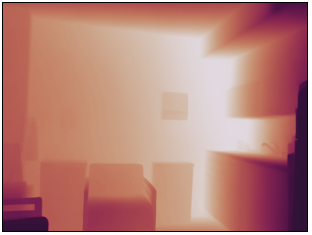

In [4]:
depth_estim = torch.load('tmp/depthmap.pt')[0]
import jhutil; jhutil.jhprint(2222, depth_estim)
depth_estim.chans

[2024-02-06 22:59:25] [INFO] Created a temporary directory at /tmp/tmpfz2gvoi_
[2024-02-06 22:59:25] [INFO] Writing /tmp/tmpfz2gvoi_/_remote_module_non_scriptable.py


/tmp/ipykernel_59877/458096239.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(cluster_map).chans


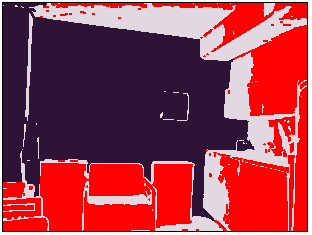

In [5]:
from src.utils.depth_utils import compute_scale_and_shift, cluster_depth_map
cluster_map = cluster_depth_map(depth_estim, eps=1.4, min_samples=4).cuda()
torch.tensor(cluster_map).chans

In [6]:
depth_gt_sparse = batch["dep"][0][0]
new_depth = torch.zeros_like(depth_estim)

for i in range(cluster_map.max() + 1):
    cluster = (cluster_map == i)
    cluster_depth = cluster * depth_gt_sparse
    if cluster_depth.sum() == 0:
        continue
    
    mask = cluster_depth != 0
    scale, shift = compute_scale_and_shift(depth_estim[None, :], depth_gt_sparse[None, :], mask[None, :])
    new_depth[cluster] = scale * depth_estim[cluster] + shift


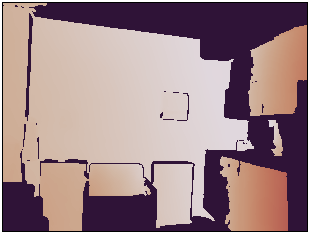

In [7]:
((new_depth - new_depth.min()) / (new_depth.max() - new_depth.min())).chans

/tmp/ipykernel_59877/197900226.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(cluster_map / 120).chans


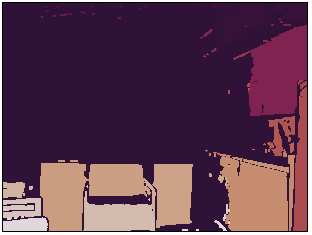

In [8]:
torch.tensor(cluster_map / 120).chans

In [9]:
cluster_map

tensor[228, 304] i64 n=69312 (0.5Mb) x∈[-1, 120] μ=23.479 σ=37.546 cuda:0

## Fill unclustered for comparison

In [10]:
mask = depth_gt_sparse != 0
scale, shift = compute_scale_and_shift(depth_estim[None, :], depth_gt_sparse[None, :], mask[None, :])
scaled_depth = scale * depth_estim + shift

In [11]:
mask = new_depth == 0
new_depth[mask] = scaled_depth[mask]

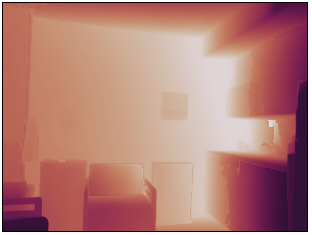

In [12]:
((new_depth - new_depth.min()) / (new_depth.max() - new_depth.min())).chans

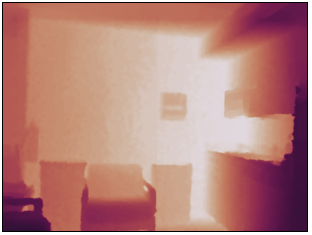

In [13]:
((depth_gt - depth_gt.min()) / (depth_gt.max() - depth_gt.min())).chans

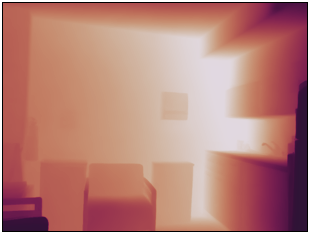

In [14]:
((scaled_depth - scaled_depth.min()) / (scaled_depth.max() - scaled_depth.min())).chans

## Diff comparison

In [15]:
dbscan_diff = (new_depth - depth_gt) * ~mask
affine_diff = (scaled_depth - depth_gt) * ~mask

In [16]:
dbscan_diff.abs().mean()

tensor cuda:0 0.038

In [17]:
affine_diff.abs().mean()

tensor cuda:0 0.043

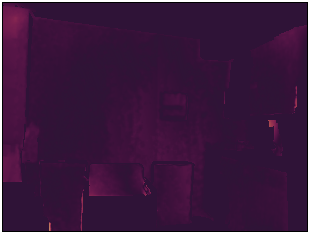

In [20]:
dbscan_diff.abs().chans

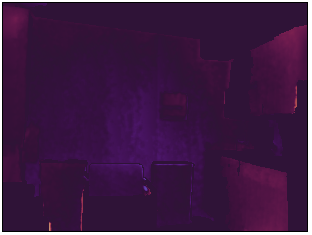

In [33]:
affine_diff.chans

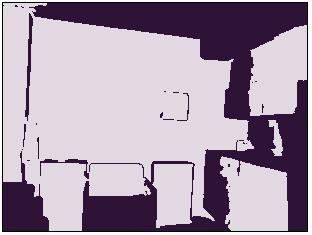

In [50]:
(~mask).chans

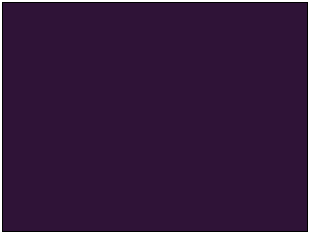

In [47]:
(affine_diff * mask).chans

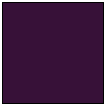

In [43]:
(torch.ones(100, 100) * 0.05).chans